In [1]:
import torch
import numpy as np
torch.manual_seed(2022201)
np.random.seed(2022201)
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

# dataset directory
dataset_dir = "/kaggle/input/cv-hw1-2022201/data/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final"

# Define class labels mapping
class_mapping = {
    'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3,
    'brown_bear': 4, 'dog': 5, 'roe_deer': 6, 'sika_deer': 7,
    'wild_boar': 8, 'people': 9
}

# Define Number of classes
num_classes = len(class_mapping)

# Transformations Used by Resnet
resnet18_transform = transforms.Compose([
    transforms.Resize(256),  # Resize shorter side to 256 while maintaining aspect ratio
    transforms.CenterCrop(224),  # Crop to 224x224 at the center
    transforms.ToTensor(),  # Convert image to tensor (C, H, W) in range [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Custom Dataset class
class RussianWildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, preload=True):
        self.image_paths = image_paths
        self.transform = transform
        self.preload = preload
        self.labels = torch.tensor(labels, dtype=torch.long)

        # Preload data into RAM if preload=True
        if self.preload:
            self.preloaded_data = [self.process_image(img_path) for img_path in self.image_paths]

    def process_image(self, img_path):
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.preloaded_data[idx] if self.preload else self.process_image(self.image_paths[idx])
        label = self.labels[idx]
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for class_name, class_id in class_mapping.items():
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue  # Skip if directory doesn't exist

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image_paths.append(img_path)
        labels.append(class_id)


# Perform stratified random split of the data in the ratio 0.8:0.2 to get the train and validation sets.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Create train and validation datasets
train_dataset = RussianWildlifeDataset(train_paths, train_labels, transform=resnet18_transform)
val_dataset = RussianWildlifeDataset(val_paths, val_labels, transform=resnet18_transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)#, num_workers=2, pin_memory=True, persistent_workers=True)

# Dataset Sizes
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 9334
Validation Dataset Size: 2334


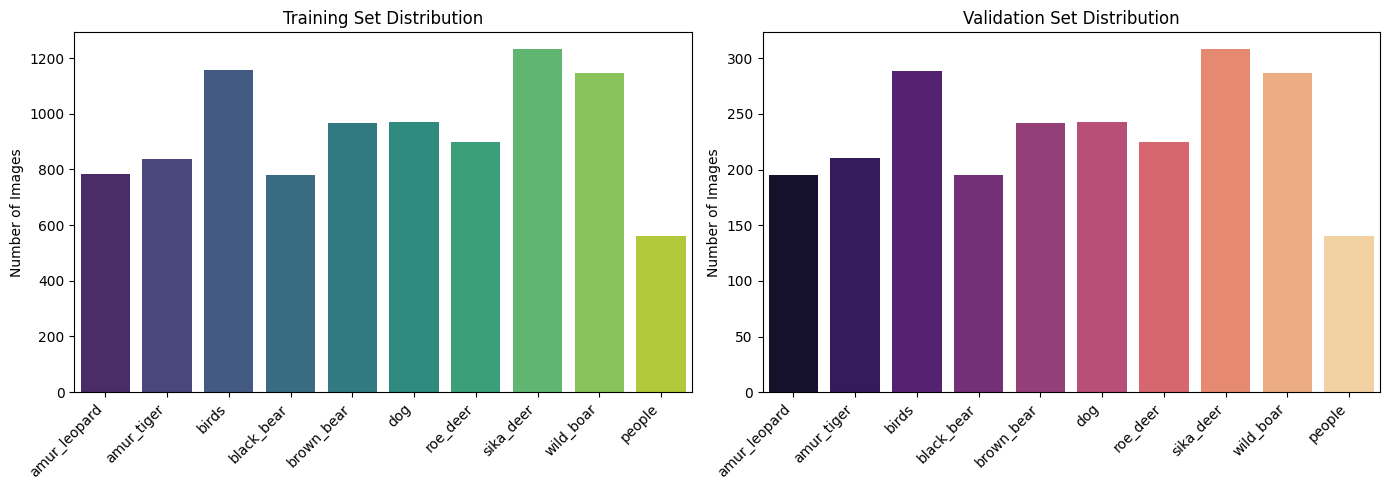

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count occurrences of each class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Sort by class index for consistency
train_counts = dict(sorted(train_counts.items()))
val_counts = dict(sorted(val_counts.items()))

# Get class names for better visualization
class_labels = [list(class_mapping.keys())[list(class_mapping.values()).index(i)] for i in train_counts.keys()]

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
sns.barplot(x=np.array(class_labels), y=np.array(list(train_counts.values())), ax=axes[0], palette="viridis")
axes[0].set_title("Training Set Distribution")
axes[0].set_ylabel("Number of Images")
axes[0].set_xticks(range(len(class_labels)))
axes[0].set_xticklabels(class_labels, rotation=45, ha="right")

# Validation set distribution
sns.barplot(x=np.array(class_labels), y=np.array(list(val_counts.values())), ax=axes[1], palette="magma")
axes[1].set_title("Validation Set Distribution")
axes[1].set_ylabel("Number of Images")
axes[1].set_xticks(range(len(class_labels)))
axes[1].set_xticklabels(class_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [3]:
import torchvision
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self, num_classes:int = 10):
        super(ConvNet, self).__init__()

        self.num_classes = num_classes  # Can be set dynamically before training

        # First Conv Layer: 3 -> 32 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Second Conv Layer: 32 -> 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Conv Layer: 64 -> 128 feature maps
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input Size: 224x224, Flattened size: 14x14x128
        self.flatten = nn.Flatten()

        # Fully connected layers (classification head)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # ReLU activation
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResNet18(nn.Module):
    def __init__(self, num_classes: int=10):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Use resnet18 from torchvision with Pretrained Weights.
        in_features = self.model.fc.in_features  # Get input features of the original resenet18 (image size : 224 x 224) fc layer
        self.model.fc = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [4]:
import wandb
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from kaggle_secrets import UserSecretsClient

# Login to W&B
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=wandb_api)

# Create a folder for saving weights if it doesn't exist
os.makedirs("weights", exist_ok=True)

# Define Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, epochs=10, learning_rate=0.0003, model_name="Model"):
    """
    Train a given model and log metrics using Weights & Biases.
    """

    # Initialize WandB
    wandb.init(project="CV_A1_Classification", name=model_name)
    wandb.config.update({"epochs": epochs, "learning_rate": learning_rate})

    model = model.to(device)  # Move model to GPU/CPU
    criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam Optimizer

    print(f"-------------------------------- TRAINING {model_name} --------------------------------")
    for epoch in range(epochs):

        # Train Phase
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss /= total
        train_acc = 100.0 * correct / total

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = 100.0 * correct / total

        # Log to WandB
        wandb.log({
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_acc
        })

        print(f"Epoch [{epoch+1}/{epochs}] -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), f"weights/{model_name}.pth")

    # Predictions on Validation Set
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")  # Weighted F1-score

    # Print metrics
    print(f"\nFinal Model Performance on Validation Set:\n")
    print(f"Accuracy: {accuracy * 100:.4f}%")
    print(f"F1 Score (Weighted): {f1:.4f}")

    # Log Confusion Matrix to WandB
    wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_labels,
        preds=all_preds,
        class_names=list(class_mapping.keys())
    )})

    print(f"-------------------------------- TRAINING COMPLETED, MODEL SAVED --------------------------------")
    wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: harshu04 (harshu04-indraprastha-institute-of-information-technolog). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
convnet = ConvNet(num_classes=num_classes)
train(convnet, train_loader, val_loader, model_name="convnet")

-------------------------------- TRAINING convnet --------------------------------
Epoch [1/10] -> Train Loss: 1.9181, Train Acc: 30.99% | Val Loss: 1.6674, Val Acc: 42.25%
Epoch [2/10] -> Train Loss: 1.5378, Train Acc: 46.93% | Val Loss: 1.3533, Val Acc: 53.98%
Epoch [3/10] -> Train Loss: 1.2716, Train Acc: 56.48% | Val Loss: 1.2874, Val Acc: 56.26%
Epoch [4/10] -> Train Loss: 1.0603, Train Acc: 63.71% | Val Loss: 1.3052, Val Acc: 56.17%
Epoch [5/10] -> Train Loss: 0.8823, Train Acc: 70.32% | Val Loss: 1.2138, Val Acc: 59.47%
Epoch [6/10] -> Train Loss: 0.7042, Train Acc: 76.40% | Val Loss: 1.1575, Val Acc: 63.88%
Epoch [7/10] -> Train Loss: 0.5488, Train Acc: 81.63% | Val Loss: 1.1283, Val Acc: 64.78%
Epoch [8/10] -> Train Loss: 0.4182, Train Acc: 86.28% | Val Loss: 1.2048, Val Acc: 64.70%
Epoch [9/10] -> Train Loss: 0.3152, Train Acc: 90.45% | Val Loss: 1.2731, Val Acc: 64.87%
Epoch [10/10] -> Train Loss: 0.2556, Train Acc: 92.15% | Val Loss: 1.4077, Val Acc: 65.30%

Final Model Per

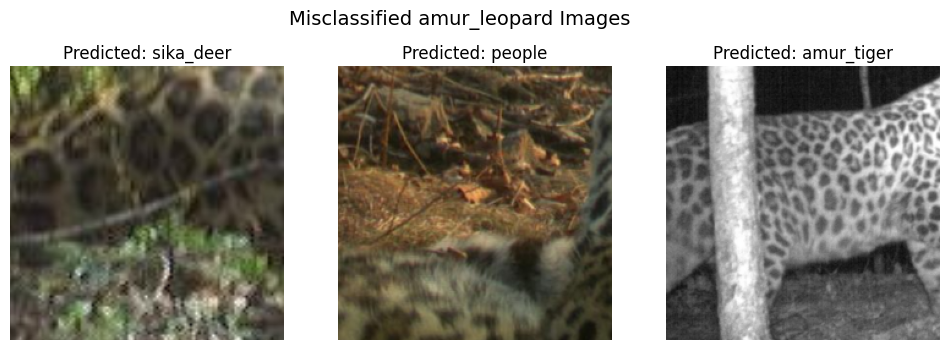

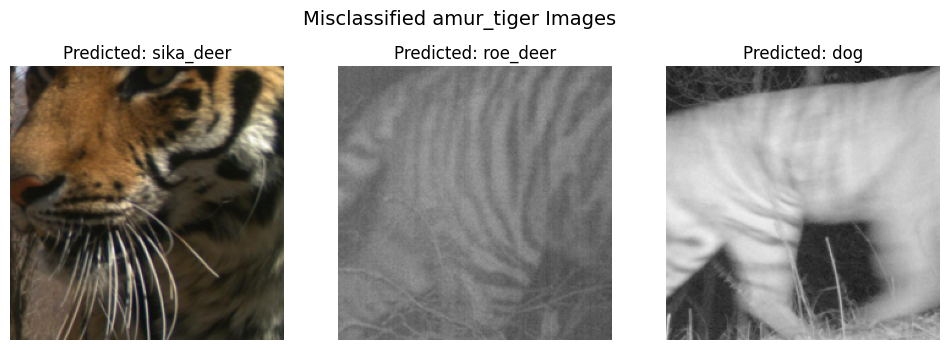

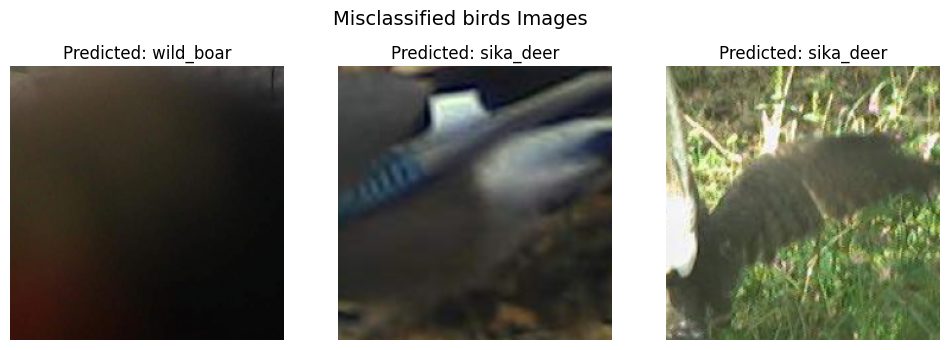

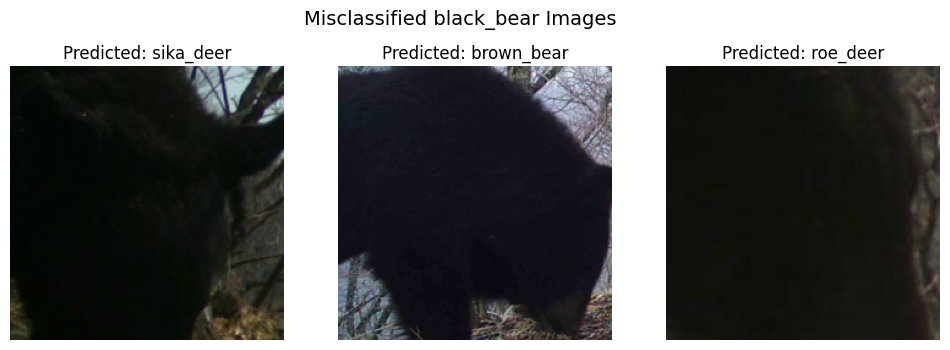

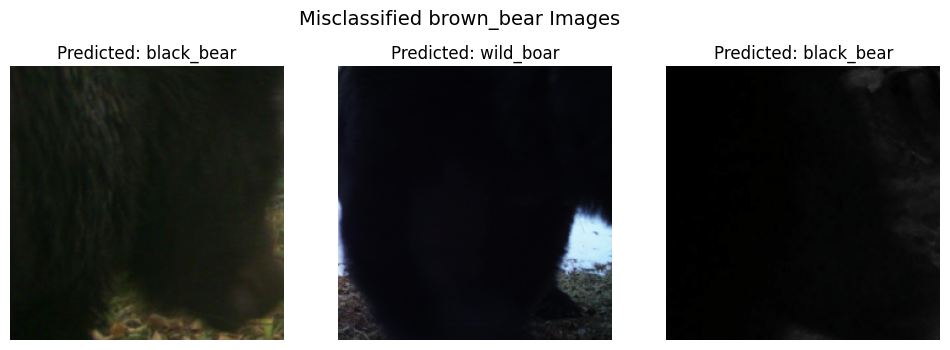

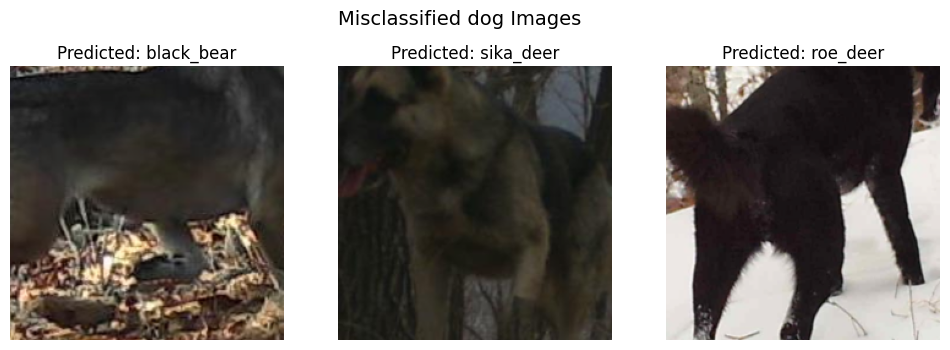

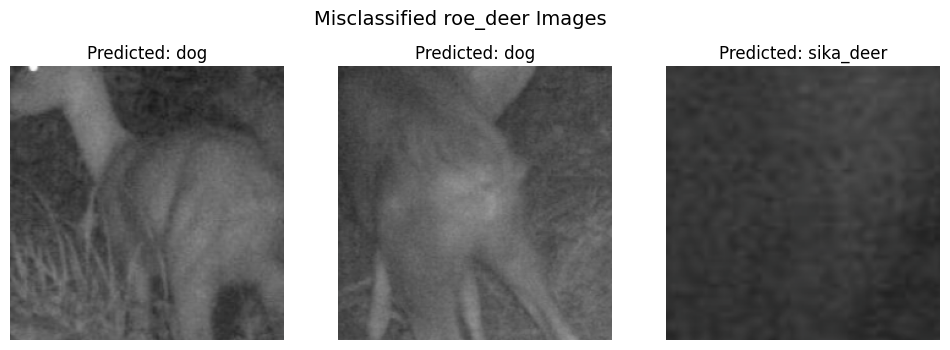

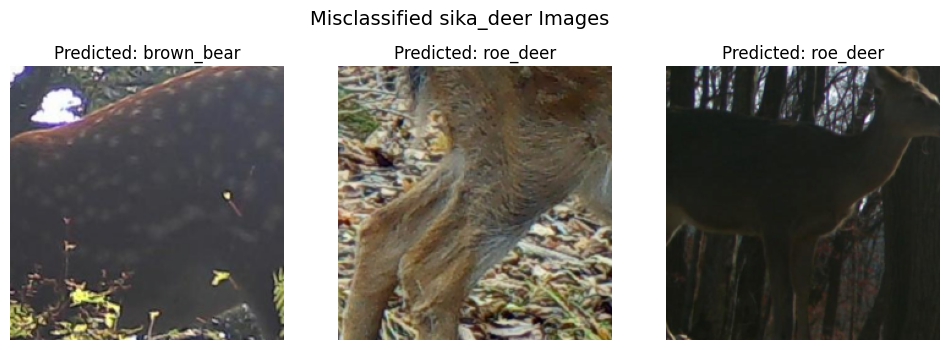

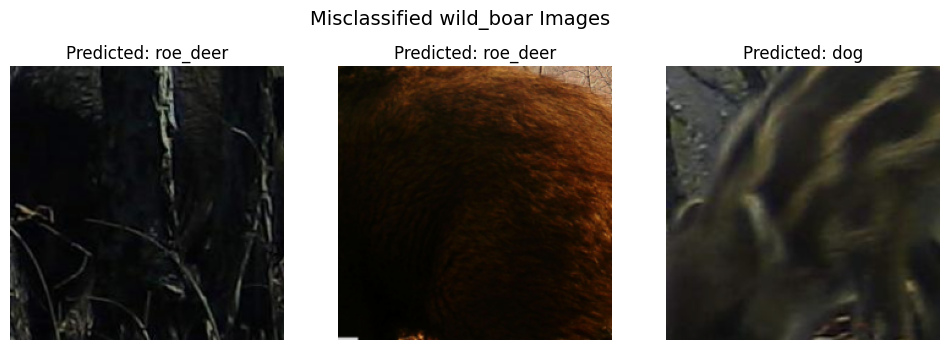

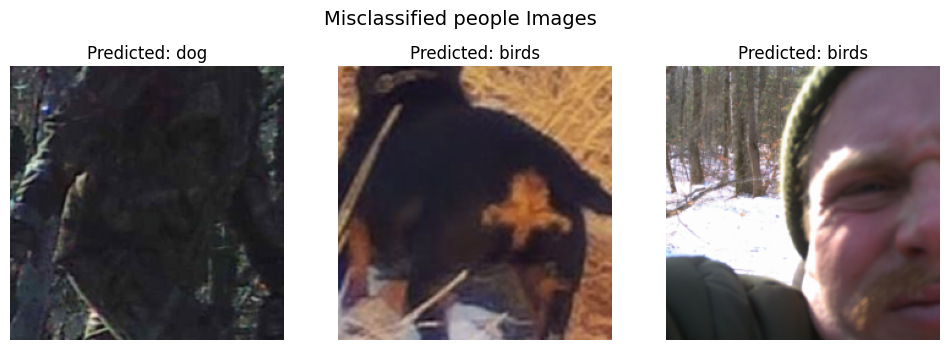

In [6]:
# Function to visualize misclassified images
def visualize_misclassified_images(model, data_loader, class_mapping, num_images_per_class=3):
    model.eval()
    misclassified_images = {cls: [] for cls in class_mapping.keys()}  # Store misclassified images per class

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Collect misclassified samples
            for img, label, pred in zip(images, labels, predicted):
                if label != pred:  # If misclassified
                    class_name = list(class_mapping.keys())[label.item()]
                    if len(misclassified_images[class_name]) < num_images_per_class:
                        misclassified_images[class_name].append((img.cpu(), pred.item()))

    # Plot misclassified images
    for class_name, img_list in misclassified_images.items():
        if len(img_list) == 0:
            continue  # Skip classes with no misclassifications

        fig, axes = plt.subplots(1, len(img_list), figsize=(12, 4))
        fig.suptitle(f"Misclassified {class_name} Images", fontsize=14)

        for i, (img, pred_label) in enumerate(img_list):
            img = img.permute(1, 2, 0).numpy()  # Convert tensor to image
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
            img = img.clip(0, 1)

            predicted_class = list(class_mapping.keys())[pred_label]

            ax = axes[i] if len(img_list) > 1 else axes
            ax.imshow(img)
            ax.set_title(f"Predicted: {predicted_class}")
            ax.axis("off")

        plt.show()

# Call function to visualize misclassified images
visualize_misclassified_images(convnet, val_loader, class_mapping)

In [7]:
resnet = ResNet18(num_classes=num_classes)
train(resnet, train_loader, val_loader, model_name="resnet")

-------------------------------- TRAINING resnet --------------------------------
Epoch [1/10] -> Train Loss: 0.7163, Train Acc: 75.23% | Val Loss: 0.5729, Val Acc: 80.59%
Epoch [2/10] -> Train Loss: 0.3433, Train Acc: 88.35% | Val Loss: 0.5005, Val Acc: 83.50%
Epoch [3/10] -> Train Loss: 0.1924, Train Acc: 93.70% | Val Loss: 0.4886, Val Acc: 85.22%
Epoch [4/10] -> Train Loss: 0.1418, Train Acc: 95.30% | Val Loss: 0.5167, Val Acc: 84.10%
Epoch [5/10] -> Train Loss: 0.0877, Train Acc: 97.24% | Val Loss: 0.6611, Val Acc: 81.71%
Epoch [6/10] -> Train Loss: 0.0887, Train Acc: 97.08% | Val Loss: 0.5458, Val Acc: 85.86%
Epoch [7/10] -> Train Loss: 0.0699, Train Acc: 97.79% | Val Loss: 0.5238, Val Acc: 85.48%
Epoch [8/10] -> Train Loss: 0.0475, Train Acc: 98.53% | Val Loss: 0.4618, Val Acc: 86.50%
Epoch [9/10] -> Train Loss: 0.0455, Train Acc: 98.48% | Val Loss: 0.5756, Val Acc: 85.22%
Epoch [10/10] -> Train Loss: 0.0946, Train Acc: 96.94% | Val Loss: 0.6441, Val Acc: 83.08%

Final Model Perf

In [8]:
backbone = nn.Sequential(*list(resnet.model.children())[:-1])  # Remove the last fc layer
backbone.eval()  # Set to evaluation mode

def extract_features(backbone, dataloader, device):
    backbone.to(device)
    features_list, labels_list = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = backbone(images)  # Extract features
            features = torch.flatten(features, 1)  # Flatten to (batch_size, feature_dim)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

train_features, train_features_labels = extract_features(backbone, train_loader, device)
val_features, val_features_labels = extract_features(backbone, val_loader, device)

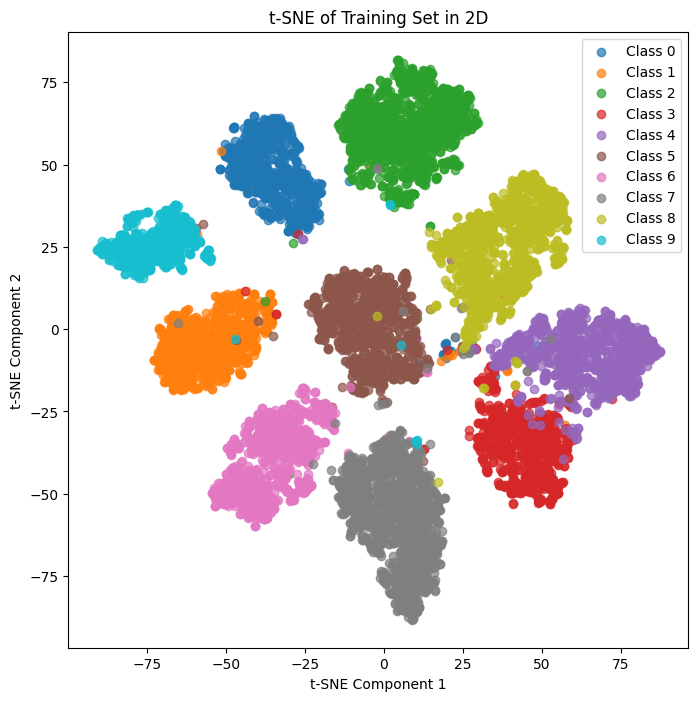

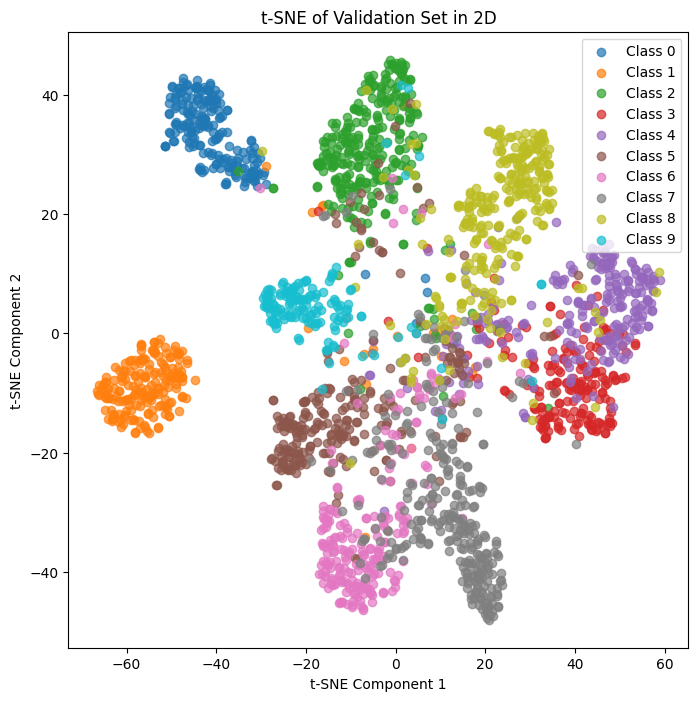

<Figure size 800x800 with 0 Axes>

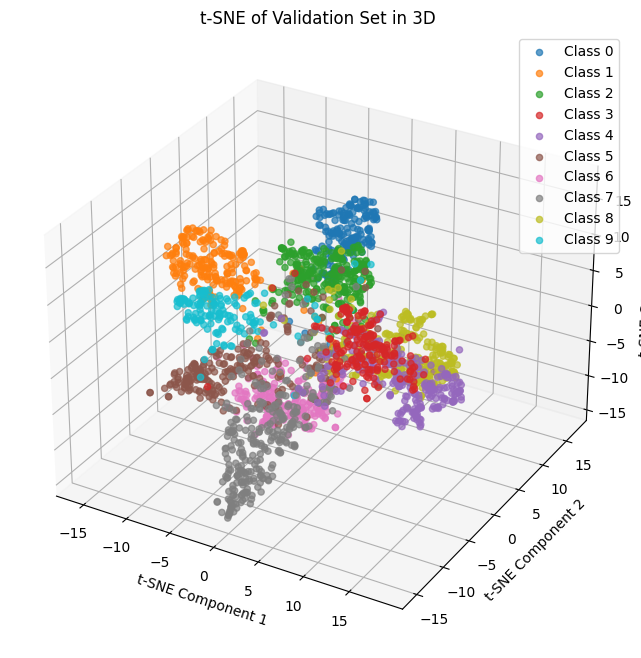

In [9]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def plot_tsne(features, labels, title="t-SNE Visualization", dim=2):
    tsne = TSNE(n_components=dim, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)

    unique_labels = np.unique(labels)
    plt.figure(figsize=(8, 8))

    if dim == 2:
        for label in unique_labels:
            idxs = labels == label
            plt.scatter(reduced_features[idxs, 0], reduced_features[idxs, 1], label=f"Class {label}", alpha=0.7)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")

    elif dim == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        for label in unique_labels:
            idxs = labels == label
            ax.scatter(reduced_features[idxs, 0], reduced_features[idxs, 1], reduced_features[idxs, 2], label=f"Class {label}", alpha=0.7)
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
        ax.set_zlabel("t-SNE Component 3")

    plt.title(title)
    plt.legend()
    plt.show()

# Plot 2D t-SNE for training data
plot_tsne(train_features, train_features_labels, title="t-SNE of Training Set in 2D", dim=2)
# Plot 2D t-SNE for validation data
plot_tsne(val_features, val_features_labels, title="t-SNE of Validation Set in 2D", dim=2)
# Plot 3D t-SNE for validation data
plot_tsne(val_features, val_features_labels, title="t-SNE of Validation Set in 3D", dim=3)

In [10]:
import random

# Define augmented transformations
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define augmented data size (40% of train_dataset)  
aug_size = int(0.4 * len(train_dataset))

# Create a second dataset with augmented transformations
aug_train_dataset = RussianWildlifeDataset(train_paths[:aug_size], train_labels[:aug_size], transform=augment_transform)

# Combine both datasets
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_train_dataset])
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True) #, num_workers=2, pin_memory=True, persistent_workers=True)

# Print new dataset size
print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Augmented Train Dataset Size: {len(aug_train_dataset)}")
print(f"Combined Train Dataset Size: {len(combined_train_dataset)}")

Original Train Dataset Size: 9334
Augmented Train Dataset Size: 4667
Combined Train Dataset Size: 14001


Original Image


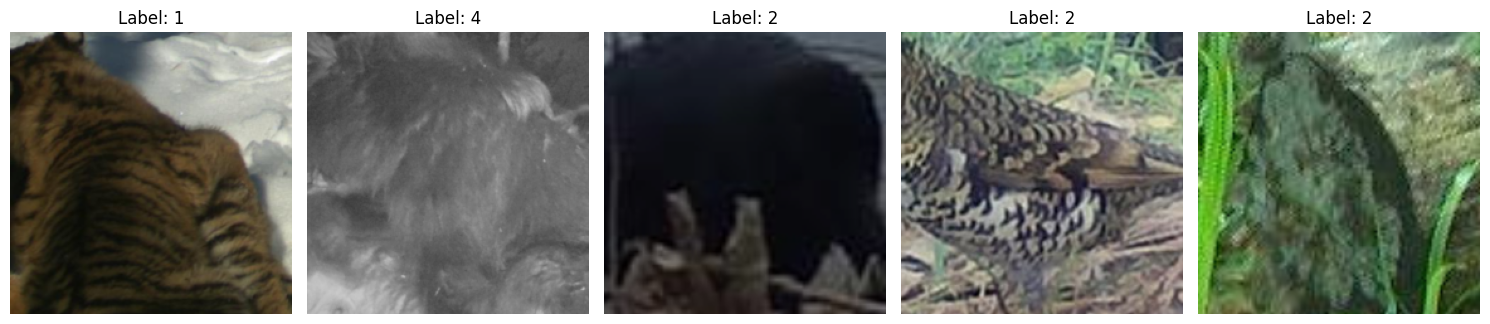

Augmented Image


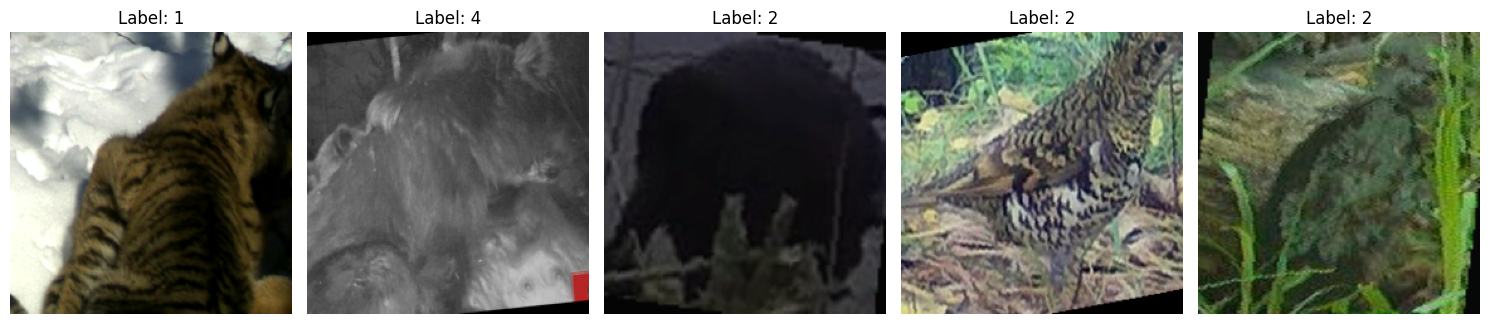

In [11]:
# Function to visualize augmented images
def visualize_images(dataset, num_images=5):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        img, label = dataset[i]  # Get image and label
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to (H, W, C) format
        img = img * std + mean  # Unnormalize
        img = img.clip(0, 1)  # Ensure values are in range [0,1]

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize 5 augmented images
print("Original Image")
visualize_images(train_dataset, num_images=5)
print("Augmented Image")
visualize_images(aug_train_dataset, num_images=5)

In [12]:
resnet_aug = ResNet18(num_classes=num_classes)
train(resnet_aug, combined_train_loader, val_loader, model_name="resnet_aug")

-------------------------------- TRAINING resnet_aug --------------------------------
Epoch [1/10] -> Train Loss: 0.6443, Train Acc: 77.39% | Val Loss: 0.4747, Val Acc: 83.20%
Epoch [2/10] -> Train Loss: 0.3133, Train Acc: 89.29% | Val Loss: 0.6034, Val Acc: 79.78%
Epoch [3/10] -> Train Loss: 0.1872, Train Acc: 93.66% | Val Loss: 0.5437, Val Acc: 83.03%
Epoch [4/10] -> Train Loss: 0.1267, Train Acc: 95.79% | Val Loss: 0.5648, Val Acc: 84.28%
Epoch [5/10] -> Train Loss: 0.1064, Train Acc: 96.44% | Val Loss: 0.5165, Val Acc: 84.40%
Epoch [6/10] -> Train Loss: 0.0851, Train Acc: 96.99% | Val Loss: 0.4914, Val Acc: 86.80%
Epoch [7/10] -> Train Loss: 0.0809, Train Acc: 97.26% | Val Loss: 0.5037, Val Acc: 86.03%
Epoch [8/10] -> Train Loss: 0.0753, Train Acc: 97.49% | Val Loss: 0.5071, Val Acc: 85.73%
Epoch [9/10] -> Train Loss: 0.0635, Train Acc: 97.98% | Val Loss: 0.5823, Val Acc: 85.26%
Epoch [10/10] -> Train Loss: 0.0348, Train Acc: 99.01% | Val Loss: 0.4706, Val Acc: 88.13%

Final Model 